In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler

import math

In [57]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'custom'


#Then update the math texts with the fonts that are needed in math mode

plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [58]:
#f = uproot.open('/Users/jshlomi/Desktop/Datasets/TruthTagging/dataset_Z.root') #dataset10M_sameFlav.root')

In [59]:
f = uproot.open('/Users/jshlomi/Desktop/Datasets/TruthTagging/dataset10M_sameFlav.root')

In [60]:
f['t1'].keys()

[b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_label',
 b'jet_score',
 b'jet_eff',
 b'jet_tag',
 b'nJets',
 b'mass']

In [61]:
n_entries = f['t1'].numentries


def collect_jets(entrystart,entry_stop):
    df = f['t1'].pandas.df(['jet_pt','jet_eta','jet_phi','jet_label','jet_eff','jet_score'],
                           entrystart=entrystart,entrystop=entry_stop).reset_index()
    df['jet_tag'] = 1*(df.jet_score < df.jet_eff)
    return df

jets_test_data = collect_jets(0,n_entries)


event_df_test = f['t1'].pandas.df(['mass'],entrystart=0,entrystop=n_entries)

In [62]:
#jets_test_data

In [63]:
#n_entries

In [64]:
jet_1_p4 = jets_test_data[['jet_eta','jet_phi']].values[jets_test_data['subentry']==0]
jet_2_p4 = jets_test_data[['jet_eta','jet_phi']].values[jets_test_data['subentry']==1]

In [65]:
def deltaphi(x):

    while len(np.where(x >= np.pi)[0]) > 0:
        x[np.where(x >= np.pi)[0]] -= 2*np.pi;
    while len(np.where(x < -np.pi)[0]) > 0: 
        x[np.where(x < -np.pi)[0]]+= 2*np.pi
    return x;

def deltaR(eta,phi,eta2,phi2):
    deta = eta-eta2
    dphi = deltaphi(phi-phi2)
    return np.sqrt( deta*deta+dphi*dphi )

In [66]:
event_df_test['dR'] = deltaR(jet_1_p4[:,0],jet_1_p4[:,1],jet_2_p4[:,0],jet_2_p4[:,1])

In [67]:
#event_df_test

## direct tagging

In [68]:
jet_1_directtag = jets_test_data['jet_tag'].values[jets_test_data['subentry']==0]
jet_2_directtag = jets_test_data['jet_tag'].values[jets_test_data['subentry']==1]

In [69]:
def compute_event_flav(jet_dataframe):

    flav_1 = jet_dataframe.loc[ jet_dataframe['subentry'] == 0 ]['jet_label'].values
    flav_2 = jet_dataframe.loc[ jet_dataframe['subentry'] == 1 ]['jet_label'].values

    bb_locations = (flav_1 == 1) & (flav_2 == 1)
    bc_locations = ((flav_1 == 1) & (flav_2 == 2)) | ((flav_1 == 2) & (flav_2 == 1))
    bl_locations = ((flav_1 == 1) & (flav_2 == 3)) | ((flav_1 == 3) & (flav_2 == 1))
    cc_locations = (flav_1 == 2) & (flav_2 == 2)
    cl_locations = ((flav_1 == 2) & (flav_2 == 3)) | ((flav_1 == 3) & (flav_2 == 2))
    ll_locations = (flav_1 == 3) & (flav_2 == 3)
    
    event_flav = np.ones(len(flav_1)).astype(str)
    
    event_flav[bb_locations] = 'bb'
    event_flav[bc_locations] = 'bc'
    event_flav[bl_locations] = 'bl'
    event_flav[cc_locations] = 'cc'
    event_flav[cl_locations] = 'cl'
    event_flav[ll_locations] = 'll'
    
    return event_flav
    
    
event_df_test['event_flav'] = compute_event_flav(jets_test_data)

In [70]:
#event_df_test

In [71]:
true_eff1 = jets_test_data.loc[ jets_test_data['subentry'] == 0 ]['jet_eff'].values
true_eff2 = jets_test_data.loc[ jets_test_data['subentry'] == 1 ]['jet_eff'].values

tt_weights_True = {
 0: (1-true_eff1)*(1-true_eff2),
 1: (true_eff1)*(1-true_eff2)+(1-true_eff1)*(true_eff2),
 2: (true_eff1)*(true_eff2)
}

tt_algos = {
    'True Efficiencies' : tt_weights_True
}

jet12_effs = {
    'True Efficiencies' : [true_eff1,true_eff2]
}

In [72]:
algorithms = [
  ['Efficiency Map','../experiments/efficiency_maps/prediction.npy'],
  ['Neural Network','../experiments/adjusted_prediction_10m.npy'],
  #['Truth Tagging with NN one net','../experiments/single_prediction_10m.npy']
#['Truth Tagging with NN','../experiments/jetset_network/adjusted_prediction.npy']
# ['Truth Tagging with NN','/Users/jshlomi/Desktop/temp_tt/adjusted_prediction.npy']
]

In [73]:
pred_all_jets = {}

for algo in algorithms:
    name = algo[0]
    path_to_pred = algo[1]
    
    pred = np.load(path_to_pred)
    pred_all_jets[name] = pred
    eff1 = pred[ jets_test_data['subentry'] == 0 ]
    eff2 = pred[ jets_test_data['subentry'] == 1 ]

    weights_dict = {
         0: (1-eff1)*(1-eff2),
         1: (eff1)*(1-eff2)+(1-eff1)*(eff2),
         2: (eff1)*(eff2)
    }
    
    jet12_effs[name] = [eff1,eff2]
    tt_algos[name] = weights_dict

In [74]:
algo_colors = {
'Efficiency Map':'cornflowerblue',
'Neural Network': 'red'
}

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


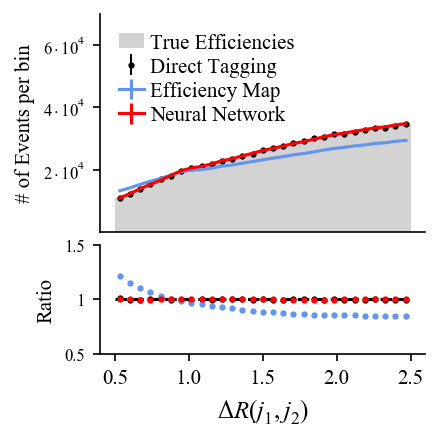

In [78]:
ntags = 2

fig,ax = plt.subplots(2,1,figsize=(2.8,3.0),gridspec_kw={'height_ratios':[2,1],'hspace':0.08},dpi=150)

ax_i = ax[0]
ax_j = ax[1]

if ntags==0:
    tag_condition = (jet_1_directtag == 0) & (jet_2_directtag == 0)
elif ntags==1:
    tag_condition = (((jet_1_directtag == 1) & (jet_2_directtag == 0)) 
                     | ((jet_1_directtag == 0) & (jet_2_directtag == 1)) )
elif ntags==2:
    tag_condition = (jet_1_directtag == 1) & (jet_2_directtag == 1)

dr_binning = np.linspace(0.5,2.5,30)



h_dt = np.histogram(event_df_test['dR'].values[tag_condition]
                 ,bins=dr_binning) #label='Direct Tagging',histtype='step'
dt_errors = np.sqrt(h_dt[0])



h_true = np.histogram(event_df_test['dR'].values, 
                   weights=tt_algos['True Efficiencies'][ntags]
                 ,bins=dr_binning)


#ax_i.text(1000,np.amax(h_true[0])*0.5,'Event Flavor: '+event_flav,ha='right',va='center',fontsize=10)
bin_centers = [(dr_binning[i+1]+dr_binning[i])/2 for i in range(len(dr_binning)-1)]
bin_width = (bin_centers[1]-bin_centers[0])



ax_i.bar(bin_centers,h_true[0],width=bin_width,label='True Efficiencies',color='lightgray',ec=None)


ax_i.errorbar(bin_centers,h_dt[0],yerr=dt_errors,markersize=2,c='k',marker='o',elinewidth=1,linewidth=0,label='Direct Tagging')

ax_j.plot([dr_binning[0],dr_binning[-1]],[1,1],color='k',linestyle='--')

ax_j.errorbar(bin_centers,h_dt[0]/h_true[0],yerr=dt_errors/h_true[0],
              label='Direct Tagging/true eff',markersize=2,c='k',marker='o',elinewidth=1,linewidth=0) #/h_true[0]
algo_i = -1

ax_i.set_ylabel('# of Events per bin',fontsize=10)
ax_j.set_ylabel('Ratio',fontsize=10)

for algo, weights_dict in tt_algos.items():
    if algo == 'True Efficiencies':
        continue
    algo_i+=1
#         h_tt = ax_i.hist(event_df_test['mass'][flav_cut],weights=weights_dict[ntags][flav_cut],histtype='step',
#               bins=mass_binning,
#               label=algo,
#             color=algo_colors[algo],linewidth=2)
    h_tt = np.histogram(event_df_test['dR'],weights=weights_dict[ntags],
          bins=dr_binning)
    h_tt_weights_squared = np.histogram(event_df_test['dR'],weights=weights_dict[ntags]**2,
          bins=dr_binning)
#               label=algo,,histtype='step'
#             color=algo_colors[algo],linewidth=2)
    ax_i.errorbar(bin_centers,h_tt[0],yerr=np.sqrt(h_tt_weights_squared[0]), color=algo_colors[algo],label=algo)
    #ax_i.bar(bin_centers+algo_i*bin_width*0.3,h_tt[0],width=0.5*bin_width,label=algo,color=algo_colors[algo])
    #ax_j.plot(bin_centers,h_tt[0]/h_true[0],label=algo+'/true eff', color=algo_colors[algo])
    ax_j.errorbar(bin_centers,h_tt[0]/h_true[0],yerr=np.sqrt(h_tt_weights_squared[0])/h_true[0],
                  markersize=2,marker='o',elinewidth=1,linewidth=0,
                  label=algo+'/true eff', color=algo_colors[algo])

ax_i.spines['right'].set_visible(False)
ax_i.spines['top'].set_visible(False)
ax_j.spines['right'].set_visible(False)
ax_j.spines['top'].set_visible(False)
ax_i.set_xticks([])
ax_j.set_ylim(0.5,1.5)
ax_i.legend(fontsize=10,loc='upper left',frameon=False,fancybox=False,shadow=False,#bbox_to_anchor=(0.4,0.8)
       handletextpad=0.3,labelspacing=0.2,handlelength=1.2)
#ax_i.set_ylim(0,n_tag_range[ntags])
ax_j.set_xlabel(r'$\Delta R(j_{1},j_{2})$',fontsize=12)

ax_i.set_ylim(0,70000)
ax_i.set_yticks([20000,40000,60000])
ax_i.set_yticklabels([r'$2\cdot 10^4$',r'$4\cdot 10^4$',r'$6\cdot 10^4$'],fontsize=8)

ax_j.set_yticklabels([0.5,1,1.5],fontsize=8)
#ax_i.set_title(event_flav+' '+str(ntags)+' Tag Region',fontsize=12)
#ax_i.legend()
plt.tight_layout()

target_dir = '/Users/jshlomi/Desktop/temp_tt/paper/5e333eb35e63e000015ede68/figures/perf_plots/mjj/'
plt.savefig(target_dir+'dr.pdf',bbox_inches='tight')
plt.show()

0.09901676231376877 0.9385354408226285
0.017193539068102837 0.12495172768831253


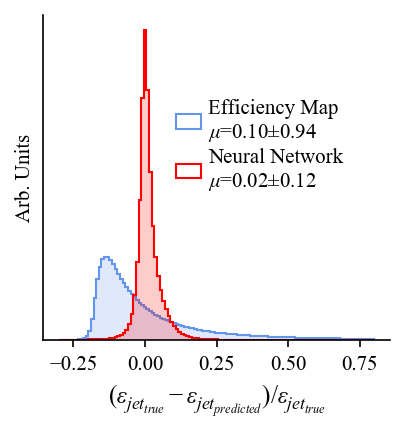

In [77]:
from matplotlib import colors

fig,ax = plt.subplots(figsize=(2.8,3.0),dpi=150)


true_eff = jets_test_data['jet_eff']



algo_i = -1

#ax_i.set_ylabel('# of Events per bin',fontsize=10)

for algo, _ in tt_algos.items():
    if algo == 'True Efficiencies':
        continue
    algo_i+=1
    pred_effs = pred_all_jets[algo]
    
    
    
    resid = (pred_effs[true_eff>0]-true_eff[true_eff>0])/true_eff[true_eff>0]
    #resid = (pred_effs-true_eff)/true_eff
    
    mean = np.mean(resid)
    std = np.std(resid)
    print(mean,std)
    rgb_c = colors.to_rgba(algo_colors[algo])
    
    rgb_c = (rgb_c[0],rgb_c[1],rgb_c[2],0.2)
    binning = np.linspace(-0.3,0.8,120)
    ax.hist(resid,bins=binning,ec='none',facecolor=rgb_c,density=True)
    ax.hist(resid,bins=binning,
            label=''+algo+'\n$\mu$={0:.2f}'.format(mean)+'$\pm$'+'{0:.2f}'.format(std),
            ec=algo_colors[algo],histtype='step',density=True)
ax.legend(fontsize=10,bbox_to_anchor=(0.33,0.8),frameon=False,fancybox=True,shadow=False,#bbox_to_anchor=(0.4,0.8)
       handletextpad=0.3,labelspacing=0.2,handlelength=1.2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel(r'$(\epsilon_{jet_{true}}-\epsilon_{jet_{predicted}})/\epsilon_{jet_{true}}$',fontsize=12)
#ax.set_xlabel(r'$(\epsilon_{true}-\epsilon_{predicted})/\epsilon_{true}$',fontsize=12)
ax.set_yticks([])
ax.set_ylabel('Arb. Units',fontsize=10)
plt.tight_layout()
target_dir = '/Users/jshlomi/Desktop/temp_tt/paper/5e333eb35e63e000015ede68/figures/perf_plots/mjj/'
plt.savefig(target_dir+'resid_jet.pdf',bbox_inches='tight')
plt.show() 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


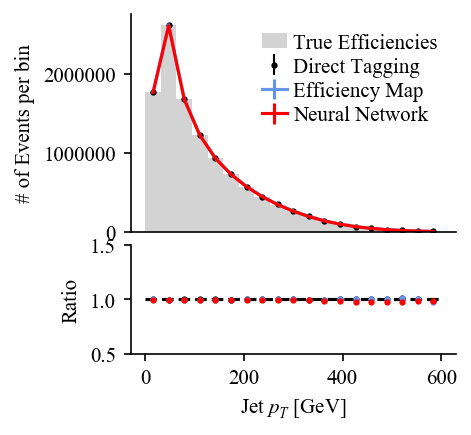

In [35]:
fig,ax = plt.subplots(2,1,figsize=(2.8,3.0),gridspec_kw={'height_ratios':[2,1],'hspace':0.08},dpi=150)

ax_i = ax[0]
ax_j = ax[1]



pt_binning = np.linspace(0,600,20)

tag_condition = jets_test_data['jet_tag'].values > 0

h_dt = np.histogram(jets_test_data['jet_pt'].values[tag_condition]
                 ,bins=pt_binning) #label='Direct Tagging',histtype='step'
dt_errors = np.sqrt(h_dt[0])



h_true = np.histogram(jets_test_data['jet_pt'].values, 
                   weights=jets_test_data['jet_eff']
                 ,bins=pt_binning)


#ax_i.text(1000,np.amax(h_true[0])*0.5,'Event Flavor: '+event_flav,ha='right',va='center',fontsize=10)
bin_centers = [(pt_binning[i+1]+pt_binning[i])/2 for i in range(len(pt_binning)-1)]
bin_width = (bin_centers[1]-bin_centers[0])



ax_i.bar(bin_centers,h_true[0],width=bin_width,label='True Efficiencies',color='lightgray',ec=None)


ax_i.errorbar(bin_centers,h_dt[0],yerr=dt_errors,markersize=2,c='k',marker='o',elinewidth=1,linewidth=0,label='Direct Tagging')

ax_j.plot([pt_binning[0],pt_binning[-1]],[1,1],color='k',linestyle='--')

ax_j.errorbar(bin_centers,h_dt[0]/h_true[0],yerr=dt_errors/h_true[0],
              label='Direct Tagging/true eff',markersize=2,c='k',marker='o',elinewidth=1,linewidth=0) #/h_true[0]
algo_i = -1

ax_i.set_ylabel('# of Events per bin',fontsize=10)
ax_j.set_ylabel('Ratio',fontsize=10)

for algo, _ in tt_algos.items():
    if algo == 'True Efficiencies':
        continue
    algo_i+=1

    h_tt = np.histogram(jets_test_data['jet_pt'].values,weights=pred_all_jets[algo],
          bins=pt_binning)
    h_tt_weights_squared = np.histogram(jets_test_data['jet_pt'].values,weights=pred_all_jets[algo]**2,
          bins=pt_binning)
#               label=algo,,histtype='step'
#             color=algo_colors[algo],linewidth=2)
    ax_i.errorbar(bin_centers,h_tt[0],yerr=np.sqrt(h_tt_weights_squared[0]), color=algo_colors[algo],label=algo)
    #ax_i.bar(bin_centers+algo_i*bin_width*0.3,h_tt[0],width=0.5*bin_width,label=algo,color=algo_colors[algo])
    #ax_j.plot(bin_centers,h_tt[0]/h_true[0],label=algo+'/true eff', color=algo_colors[algo])
    ax_j.errorbar(bin_centers,h_tt[0]/h_true[0],yerr=np.sqrt(h_tt_weights_squared[0])/h_true[0],
                  markersize=2,marker='o',elinewidth=1,linewidth=0,
                  label=algo+'/true eff', color=algo_colors[algo])

ax_i.spines['right'].set_visible(False)
ax_i.spines['top'].set_visible(False)
ax_j.spines['right'].set_visible(False)
ax_j.spines['top'].set_visible(False)
ax_i.set_xticks([])
ax_j.set_ylim(0.5,1.5)
ax_i.legend(fontsize=10,loc='upper right',frameon=False,fancybox=False,shadow=False,#bbox_to_anchor=(0.4,0.8)
       handletextpad=0.3,labelspacing=0.2,handlelength=1.2)
#ax_i.set_ylim(0,n_tag_range[ntags])
ax_j.set_xlabel(r'Jet $p_{T}$ [GeV]')

#ax_i.set_ylim(0,70000)
#ax_i.set_yticks([20000,40000,60000])
#ax_i.set_yticklabels([r'$2\cdot 10^4$',r'$4\cdot 10^4$',r'$6\cdot 10^4$'],fontsize=8)

#ax_j.set_yticklabels([0.5,1,1.5],fontsize=8)
#ax_i.set_title(event_flav+' '+str(ntags)+' Tag Region',fontsize=12)
#ax_i.legend()
plt.tight_layout()

target_dir = '/Users/jshlomi/Desktop/temp_tt/paper/5e333eb35e63e000015ede68/figures/perf_plots/mjj/'
#plt.savefig(target_dir+'dr.pdf',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


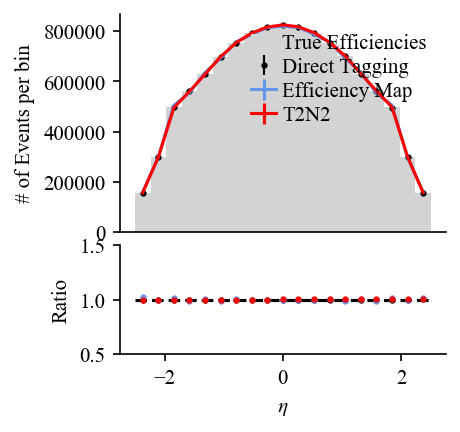

In [239]:
fig,ax = plt.subplots(2,1,figsize=(2.8,3.0),gridspec_kw={'height_ratios':[2,1],'hspace':0.08},dpi=150)

ax_i = ax[0]
ax_j = ax[1]



eta_binning = np.linspace(-2.5,2.5,20)

tag_condition = jets_test_data['jet_tag'].values > 0

h_dt = np.histogram(jets_test_data['jet_eta'].values[tag_condition]
                 ,bins=eta_binning) #label='Direct Tagging',histtype='step'
dt_errors = np.sqrt(h_dt[0])



h_true = np.histogram(jets_test_data['jet_eta'].values, 
                   weights=jets_test_data['jet_eff']
                 ,bins=eta_binning)


#ax_i.text(1000,np.amax(h_true[0])*0.5,'Event Flavor: '+event_flav,ha='right',va='center',fontsize=10)
bin_centers = [(eta_binning[i+1]+eta_binning[i])/2 for i in range(len(eta_binning)-1)]
bin_width = (bin_centers[1]-bin_centers[0])



ax_i.bar(bin_centers,h_true[0],width=bin_width,label='True Efficiencies',color='lightgray',ec=None)


ax_i.errorbar(bin_centers,h_dt[0],yerr=dt_errors,markersize=2,c='k',marker='o',elinewidth=1,linewidth=0,label='Direct Tagging')

ax_j.plot([eta_binning[0],eta_binning[-1]],[1,1],color='k',linestyle='--')

ax_j.errorbar(bin_centers,h_dt[0]/h_true[0],yerr=dt_errors/h_true[0],
              label='Direct Tagging/true eff',markersize=2,c='k',marker='o',elinewidth=1,linewidth=0) #/h_true[0]
algo_i = -1

ax_i.set_ylabel('# of Events per bin',fontsize=10)
ax_j.set_ylabel('Ratio',fontsize=10)

for algo, _ in tt_algos.items():
    if algo == 'True Efficiencies':
        continue
    algo_i+=1

    h_tt = np.histogram(jets_test_data['jet_eta'].values,weights=pred_all_jets[algo],
          bins=eta_binning)
    h_tt_weights_squared = np.histogram(jets_test_data['jet_eta'].values,weights=pred_all_jets[algo]**2,
          bins=eta_binning)
#               label=algo,,histtype='step'
#             color=algo_colors[algo],linewidth=2)
    ax_i.errorbar(bin_centers,h_tt[0],yerr=np.sqrt(h_tt_weights_squared[0]), color=algo_colors[algo],label=algo)
    #ax_i.bar(bin_centers+algo_i*bin_width*0.3,h_tt[0],width=0.5*bin_width,label=algo,color=algo_colors[algo])
    #ax_j.plot(bin_centers,h_tt[0]/h_true[0],label=algo+'/true eff', color=algo_colors[algo])
    ax_j.errorbar(bin_centers,h_tt[0]/h_true[0],yerr=np.sqrt(h_tt_weights_squared[0])/h_true[0],
                  markersize=2,marker='o',elinewidth=1,linewidth=0,
                  label=algo+'/true eff', color=algo_colors[algo])

ax_i.spines['right'].set_visible(False)
ax_i.spines['top'].set_visible(False)
ax_j.spines['right'].set_visible(False)
ax_j.spines['top'].set_visible(False)
ax_i.set_xticks([])
ax_j.set_ylim(0.5,1.5)
ax_i.legend(fontsize=10,loc='upper right',frameon=False,fancybox=False,shadow=False,#bbox_to_anchor=(0.4,0.8)
       handletextpad=0.3,labelspacing=0.2,handlelength=1.2)
#ax_i.set_ylim(0,n_tag_range[ntags])
ax_j.set_xlabel(r'Jet $\eta$')

#ax_i.set_ylim(0,70000)
#ax_i.set_yticks([20000,40000,60000])
#ax_i.set_yticklabels([r'$2\cdot 10^4$',r'$4\cdot 10^4$',r'$6\cdot 10^4$'],fontsize=8)

#ax_j.set_yticklabels([0.5,1,1.5],fontsize=8)
#ax_i.set_title(event_flav+' '+str(ntags)+' Tag Region',fontsize=12)
#ax_i.legend()
plt.tight_layout()

target_dir = '/Users/jshlomi/Desktop/temp_tt/paper/5e333eb35e63e000015ede68/figures/perf_plots/mjj/'
#plt.savefig(target_dir+'dr.pdf',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


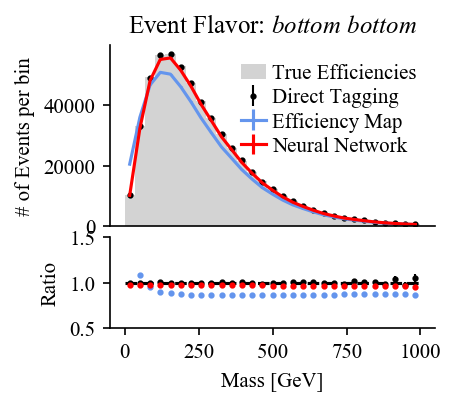

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


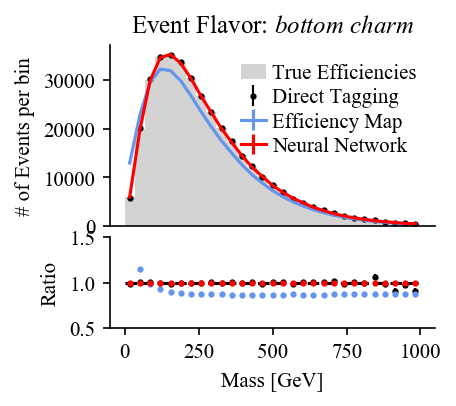

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


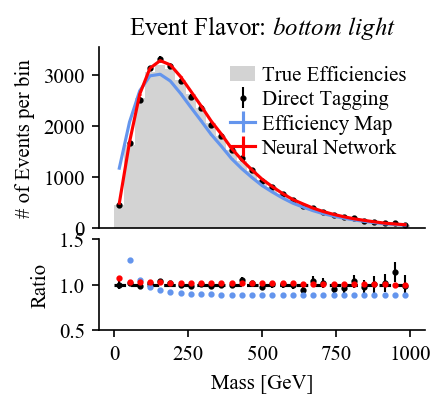

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


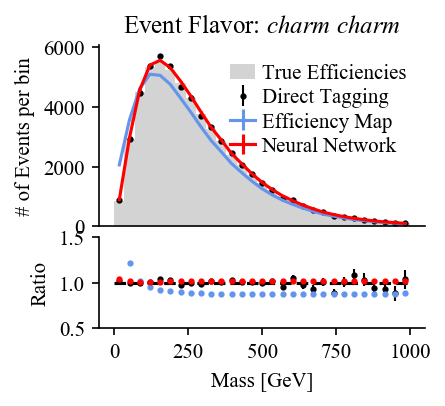

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


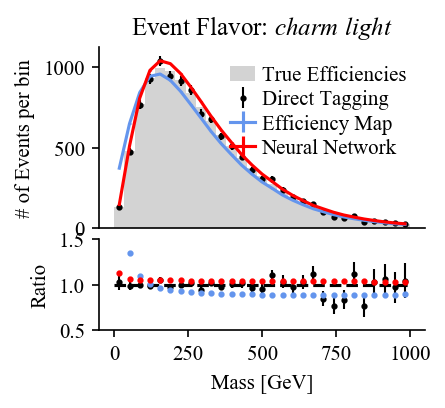

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


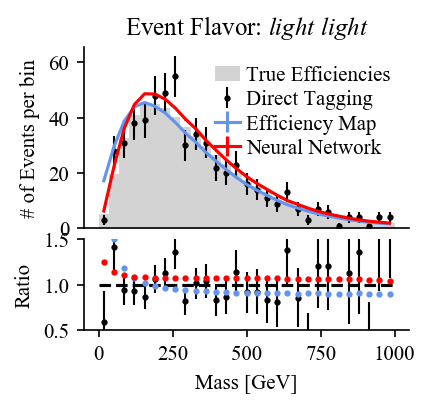

In [37]:
event_flavs = [
'bb',
'bc',
'bl',
'cc',
'cl',
'll',
]
latex_names = {
    'bb' : '$bottom$ $bottom$',
    'bc' : '$bottom$ $charm$',
'bl': '$bottom$ $light$',
'cc': '$charm$ $charm$',
'cl': '$charm$ $light$',
    'll' : '$light$ $light$'
    
}
n_flavs = len(event_flavs)
n_tag_range = {
    0 : 7500,
    1 : 7000,
    2 : 2000
}

algo_colors = {
'Efficiency Map':'cornflowerblue',
'Neural Network': 'red'
}

ntags = 2
for event_flav_i, event_flav in enumerate( event_flavs):
    fig,ax = plt.subplots(2,1,figsize=(2.8,2.5),gridspec_kw={'height_ratios':[2,1],'hspace':0.08}
                     ,dpi=150)

    ax_i = ax[0]
    ax_j = ax[1]
    flav_cut = event_df_test['event_flav'] == event_flav
    if ntags==0:
        tag_condition = (jet_1_directtag == 0) & (jet_2_directtag == 0)
    elif ntags==1:
        tag_condition = (((jet_1_directtag == 1) & (jet_2_directtag == 0)) 
                         | ((jet_1_directtag == 0) & (jet_2_directtag == 1)) )
    elif ntags==2:
        tag_condition = (jet_1_directtag == 1) & (jet_2_directtag == 1)

    mass_binning = np.linspace(0,1000,30)
    
    
    
    h_dt = np.histogram(event_df_test['mass'].values[tag_condition & flav_cut]
                     ,bins=mass_binning) #label='Direct Tagging',histtype='step'
    dt_errors = np.sqrt(h_dt[0])


    
    h_true = np.histogram(event_df_test['mass'].values[flav_cut], 
                       weights=tt_algos['True Efficiencies'][ntags][flav_cut]
                     ,bins=mass_binning)
    
    
    #ax_i.text(1000,np.amax(h_true[0])*0.5,'Event Flavor: '+event_flav,ha='right',va='center',fontsize=10)
    ax_i.set_title(r'Event Flavor: '+latex_names[event_flav])
    bin_centers = [(mass_binning[i+1]+mass_binning[i])/2 for i in range(len(mass_binning)-1)]
    bin_width = (bin_centers[1]-bin_centers[0])
    
    
    
    ax_i.bar(bin_centers,h_true[0],width=bin_width,label='True Efficiencies',color='lightgray',ec=None)
    
    
    ax_i.errorbar(bin_centers,h_dt[0],yerr=dt_errors,markersize=2,c='k',marker='o',elinewidth=1,linewidth=0,label='Direct Tagging')
    
    ax_j.plot([mass_binning[0],mass_binning[-1]],[1,1],color='k',linestyle='--')

    ax_j.errorbar(bin_centers,h_dt[0]/h_true[0],yerr=dt_errors/h_true[0],
                  label='Direct Tagging/true eff',markersize=2,c='k',marker='o',elinewidth=1,linewidth=0) #/h_true[0]
    algo_i = -1
    
    ax_i.set_ylabel('# of Events per bin',fontsize=10)
    ax_j.set_ylabel('Ratio',fontsize=10)
    
    for algo, weights_dict in tt_algos.items():
        if algo == 'True Efficiencies':
            continue
        algo_i+=1
#         h_tt = ax_i.hist(event_df_test['mass'][flav_cut],weights=weights_dict[ntags][flav_cut],histtype='step',
#               bins=mass_binning,
#               label=algo,
#             color=algo_colors[algo],linewidth=2)
        h_tt = np.histogram(event_df_test['mass'][flav_cut],weights=weights_dict[ntags][flav_cut],
              bins=mass_binning)
        h_tt_weights_squared = np.histogram(event_df_test['mass'][flav_cut],weights=weights_dict[ntags][flav_cut]**2,
              bins=mass_binning)
#               label=algo,,histtype='step'
#             color=algo_colors[algo],linewidth=2)
        ax_i.errorbar(bin_centers,h_tt[0],yerr=np.sqrt(h_tt_weights_squared[0]), color=algo_colors[algo],label=algo)
        #ax_i.bar(bin_centers+algo_i*bin_width*0.3,h_tt[0],width=0.5*bin_width,label=algo,color=algo_colors[algo])
        #ax_j.plot(bin_centers,h_tt[0]/h_true[0],label=algo+'/true eff', color=algo_colors[algo])
        ax_j.errorbar(bin_centers,h_tt[0]/h_true[0],yerr=np.sqrt(h_tt_weights_squared[0])/h_true[0],
                      markersize=2,marker='o',elinewidth=1,linewidth=0,
                      label=algo+'/true eff', color=algo_colors[algo])

    ax_i.spines['right'].set_visible(False)
    ax_i.spines['top'].set_visible(False)
    ax_j.spines['right'].set_visible(False)
    ax_j.spines['top'].set_visible(False)
    ax_i.set_xticks([])
    ax_j.set_ylim(0.5,1.5)
    ax_i.legend(fontsize=10,loc='upper right',frameon=False,fancybox=False,shadow=False,#bbox_to_anchor=(0.4,0.8)
           handletextpad=0.3,labelspacing=0.2,handlelength=1.2)
    #ax_i.set_ylim(0,n_tag_range[ntags])
    ax_j.set_xlabel('Mass [GeV]')
    
    
    #ax_i.set_title(event_flav+' '+str(ntags)+' Tag Region',fontsize=12)
    #ax_i.legend()
    plt.tight_layout()
    target_dir = '/Users/jshlomi/Desktop/temp_tt/paper/5e333eb35e63e000015ede68/figures/perf_plots/mjj/'
    plt.savefig(target_dir+'perf_'+event_flav+'.pdf',bbox_inches='tight')
    plt.show()

In [48]:
f = uproot.open('/Users/jshlomi/Desktop/Datasets/TruthTagging/dataset_Z.root')


n_entries = f['t1'].numentries


def collect_jets(entrystart,entry_stop):
    df = f['t1'].pandas.df(['jet_pt','jet_eta','jet_phi','jet_label','jet_eff','jet_score'],
                           entrystart=entrystart,entrystop=entry_stop).reset_index()
    df['jet_tag'] = 1*(df.jet_score < df.jet_eff)
    return df

jets_test_data = collect_jets(0,n_entries)


event_df_test = f['t1'].pandas.df(['mass'],entrystart=0,entrystop=n_entries)

In [49]:
jet_1_p4 = jets_test_data[['jet_eta','jet_phi']].values[jets_test_data['subentry']==0]
jet_2_p4 = jets_test_data[['jet_eta','jet_phi']].values[jets_test_data['subentry']==1]

In [50]:
event_df_test['dR'] = deltaR(jet_1_p4[:,0],jet_1_p4[:,1],jet_2_p4[:,0],jet_2_p4[:,1])

In [51]:
jet_1_directtag = jets_test_data['jet_tag'].values[jets_test_data['subentry']==0]
jet_2_directtag = jets_test_data['jet_tag'].values[jets_test_data['subentry']==1]

In [52]:
true_eff1 = jets_test_data.loc[ jets_test_data['subentry'] == 0 ]['jet_eff'].values
true_eff2 = jets_test_data.loc[ jets_test_data['subentry'] == 1 ]['jet_eff'].values

tt_weights_True = {
 0: (1-true_eff1)*(1-true_eff2),
 1: (true_eff1)*(1-true_eff2)+(1-true_eff1)*(true_eff2),
 2: (true_eff1)*(true_eff2)
}

tt_algos = {
    'True Efficiencies' : tt_weights_True
}

jet12_effs = {
    'True Efficiencies' : [true_eff1,true_eff2]
}

In [53]:
algorithms = [
  ['Efficiency Map','../experiments/efficiency_maps/prediction_z.npy'],
  ['Neural Network','../experiments/single_prediction_z.npy'],
  #['Truth Tagging with NN one net','../experiments/single_prediction_10m.npy']
#['Truth Tagging with NN','../experiments/jetset_network/adjusted_prediction.npy']
# ['Truth Tagging with NN','/Users/jshlomi/Desktop/temp_tt/adjusted_prediction.npy']
]

In [54]:
pred_all_jets = {}

for algo in algorithms:
    name = algo[0]
    path_to_pred = algo[1]
    
    pred = np.load(path_to_pred)
    pred_all_jets[name] = pred
    eff1 = pred[ jets_test_data['subentry'] == 0 ]
    eff2 = pred[ jets_test_data['subentry'] == 1 ]

    weights_dict = {
         0: (1-eff1)*(1-eff2),
         1: (eff1)*(1-eff2)+(1-eff1)*(eff2),
         2: (eff1)*(eff2)
    }
    
    jet12_effs[name] = [eff1,eff2]
    tt_algos[name] = weights_dict

In [55]:
algo_colors = {
'Efficiency Map':'cornflowerblue',
'Neural Network': 'red'
}

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


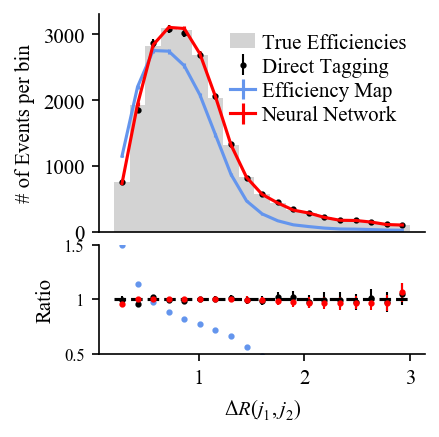

In [56]:
ntags = 2

fig,ax = plt.subplots(2,1,figsize=(2.8,3.0),gridspec_kw={'height_ratios':[2,1],'hspace':0.08},dpi=150)

ax_i = ax[0]
ax_j = ax[1]

if ntags==0:
    tag_condition = (jet_1_directtag == 0) & (jet_2_directtag == 0)
elif ntags==1:
    tag_condition = (((jet_1_directtag == 1) & (jet_2_directtag == 0)) 
                     | ((jet_1_directtag == 0) & (jet_2_directtag == 1)) )
elif ntags==2:
    tag_condition = (jet_1_directtag == 1) & (jet_2_directtag == 1)

dr_binning = np.linspace(0.2,3.0,20)



h_dt = np.histogram(event_df_test['dR'].values[tag_condition]
                 ,bins=dr_binning) #label='Direct Tagging',histtype='step'
dt_errors = np.sqrt(h_dt[0])



h_true = np.histogram(event_df_test['dR'].values, 
                   weights=tt_algos['True Efficiencies'][ntags]
                 ,bins=dr_binning)


#ax_i.text(1000,np.amax(h_true[0])*0.5,'Event Flavor: '+event_flav,ha='right',va='center',fontsize=10)
bin_centers = [(dr_binning[i+1]+dr_binning[i])/2 for i in range(len(dr_binning)-1)]
bin_width = (bin_centers[1]-bin_centers[0])



ax_i.bar(bin_centers,h_true[0],width=bin_width,label='True Efficiencies',color='lightgray',ec=None)


ax_i.errorbar(bin_centers,h_dt[0],yerr=dt_errors,markersize=2,c='k',marker='o',elinewidth=1,linewidth=0,label='Direct Tagging')

ax_j.plot([dr_binning[0],dr_binning[-1]],[1,1],color='k',linestyle='--')

ax_j.errorbar(bin_centers,h_dt[0]/h_true[0],yerr=dt_errors/h_true[0],
              label='Direct Tagging/true eff',markersize=2,c='k',marker='o',elinewidth=1,linewidth=0) #/h_true[0]
algo_i = -1

ax_i.set_ylabel('# of Events per bin',fontsize=10)
ax_j.set_ylabel('Ratio',fontsize=10)

for algo, weights_dict in tt_algos.items():
    if algo == 'True Efficiencies':
        continue
    algo_i+=1
#         h_tt = ax_i.hist(event_df_test['mass'][flav_cut],weights=weights_dict[ntags][flav_cut],histtype='step',
#               bins=mass_binning,
#               label=algo,
#             color=algo_colors[algo],linewidth=2)
    h_tt = np.histogram(event_df_test['dR'],weights=weights_dict[ntags],
          bins=dr_binning)
    h_tt_weights_squared = np.histogram(event_df_test['dR'],weights=weights_dict[ntags]**2,
          bins=dr_binning)
#               label=algo,,histtype='step'
#             color=algo_colors[algo],linewidth=2)
    ax_i.errorbar(bin_centers,h_tt[0],yerr=np.sqrt(h_tt_weights_squared[0]), color=algo_colors[algo],label=algo)
    #ax_i.bar(bin_centers+algo_i*bin_width*0.3,h_tt[0],width=0.5*bin_width,label=algo,color=algo_colors[algo])
    #ax_j.plot(bin_centers,h_tt[0]/h_true[0],label=algo+'/true eff', color=algo_colors[algo])
    ax_j.errorbar(bin_centers,h_tt[0]/h_true[0],yerr=np.sqrt(h_tt_weights_squared[0])/h_true[0],
                  markersize=2,marker='o',elinewidth=1,linewidth=0,
                  label=algo+'/true eff', color=algo_colors[algo])

ax_i.spines['right'].set_visible(False)
ax_i.spines['top'].set_visible(False)
ax_j.spines['right'].set_visible(False)
ax_j.spines['top'].set_visible(False)
ax_i.set_xticks([])
ax_j.set_ylim(0.5,1.5)
ax_i.legend(fontsize=10,loc='upper right',frameon=False,fancybox=False,shadow=False,#bbox_to_anchor=(0.4,0.8)
       handletextpad=0.3,labelspacing=0.2,handlelength=1.2)
#ax_i.set_ylim(0,n_tag_range[ntags])
ax_j.set_xlabel(r'$\Delta R(j_{1},j_{2})$')

#ax_i.set_ylim(0,70000)
#ax_i.set_yticks([20000,40000,60000])
#ax_i.set_yticklabels([r'$2\cdot 10^4$',r'$4\cdot 10^4$',r'$6\cdot 10^4$'],fontsize=8)

ax_j.set_yticklabels([0.5,1,1.5],fontsize=8)
#ax_i.set_title(event_flav+' '+str(ntags)+' Tag Region',fontsize=12)
#ax_i.legend()
plt.tight_layout()

target_dir = '/Users/jshlomi/Desktop/temp_tt/paper/5e333eb35e63e000015ede68/figures/perf_plots/zsample/'
plt.savefig(target_dir+'dr.pdf',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


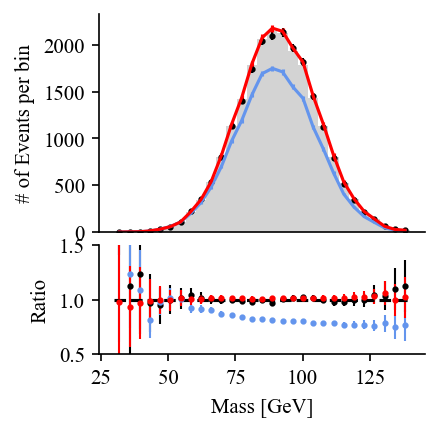

In [74]:
ntags = 2

fig,ax = plt.subplots(2,1,figsize=(2.8,3.0),gridspec_kw={'height_ratios':[2,1],'hspace':0.08},dpi=150)

ax_i = ax[0]
ax_j = ax[1]

if ntags==0:
    tag_condition = (jet_1_directtag == 0) & (jet_2_directtag == 0)
elif ntags==1:
    tag_condition = (((jet_1_directtag == 1) & (jet_2_directtag == 0)) 
                     | ((jet_1_directtag == 0) & (jet_2_directtag == 1)) )
elif ntags==2:
    tag_condition = (jet_1_directtag == 1) & (jet_2_directtag == 1)

mass_binning = np.linspace(30,140,30)



h_dt = np.histogram(event_df_test['mass'].values[tag_condition]
                 ,bins=mass_binning) #label='Direct Tagging',histtype='step'
dt_errors = np.sqrt(h_dt[0])



h_true = np.histogram(event_df_test['mass'].values, 
                   weights=tt_algos['True Efficiencies'][ntags]
                 ,bins=mass_binning)


#ax_i.text(1000,np.amax(h_true[0])*0.5,'Event Flavor: '+event_flav,ha='right',va='center',fontsize=10)
bin_centers = [(mass_binning[i+1]+mass_binning[i])/2 for i in range(len(mass_binning)-1)]
bin_width = (bin_centers[1]-bin_centers[0])



ax_i.bar(bin_centers,h_true[0],width=bin_width,label='True Efficiencies',color='lightgray',ec=None)


ax_i.errorbar(bin_centers,h_dt[0],yerr=dt_errors,markersize=2,c='k',marker='o',elinewidth=1,linewidth=0,label='Direct Tagging')

ax_j.plot([mass_binning[0],mass_binning[-1]],[1,1],color='k',linestyle='--')

ax_j.errorbar(bin_centers,h_dt[0]/h_true[0],yerr=dt_errors/h_true[0],
              label='Direct Tagging/true eff',markersize=2,c='k',marker='o',elinewidth=1,linewidth=0) #/h_true[0]
algo_i = -1

ax_i.set_ylabel('# of Events per bin',fontsize=10)
ax_j.set_ylabel('Ratio',fontsize=10)

for algo, weights_dict in tt_algos.items():
    if algo == 'True Efficiencies':
        continue
    algo_i+=1
#         h_tt = ax_i.hist(event_df_test['mass'][flav_cut],weights=weights_dict[ntags][flav_cut],histtype='step',
#               bins=mass_binning,
#               label=algo,
#             color=algo_colors[algo],linewidth=2)
    h_tt = np.histogram(event_df_test['mass'],weights=weights_dict[ntags],
          bins=mass_binning)
    h_tt_weights_squared = np.histogram(event_df_test['mass'],weights=weights_dict[ntags]**2,
          bins=mass_binning)
#               label=algo,,histtype='step'
#             color=algo_colors[algo],linewidth=2)
    ax_i.errorbar(bin_centers,h_tt[0],yerr=np.sqrt(h_tt_weights_squared[0]), color=algo_colors[algo],label=algo)
    #ax_i.bar(bin_centers+algo_i*bin_width*0.3,h_tt[0],width=0.5*bin_width,label=algo,color=algo_colors[algo])
    #ax_j.plot(bin_centers,h_tt[0]/h_true[0],label=algo+'/true eff', color=algo_colors[algo])
    ax_j.errorbar(bin_centers,h_tt[0]/h_true[0],yerr=np.sqrt(h_tt_weights_squared[0])/h_true[0],
                  markersize=2,marker='o',elinewidth=1,linewidth=0,
                  label=algo+'/true eff', color=algo_colors[algo])

ax_i.spines['right'].set_visible(False)
ax_i.spines['top'].set_visible(False)
ax_j.spines['right'].set_visible(False)
ax_j.spines['top'].set_visible(False)
ax_i.set_xticks([])
ax_j.set_ylim(0.5,1.5)
#ax_i.legend(fontsize=10,loc='upper left',frameon=False,fancybox=False,shadow=False,#bbox_to_anchor=(0.4,0.8)
#       handletextpad=0.3,labelspacing=0.2,handlelength=1.2)
#ax_i.set_ylim(0,n_tag_range[ntags])
ax_j.set_xlabel('Mass [GeV]')

#ax_i.set_ylim(0,4000)
#ax_i.set_xlim(25,150)
#ax_j.set_xlim(25,150)
#ax_i.set_yticks([100,250,400])
#ax_i.set_yticklabels([r'$2\cdot 10^4$',r'$4\cdot 10^4$',r'$6\cdot 10^4$'],fontsize=8)

#ax_j.set_yticklabels([0.5,1,1.5],fontsize=8)
#ax_i.set_title(event_flav+' '+str(ntags)+' Tag Region',fontsize=12)
#ax_i.legend()
plt.tight_layout()

target_dir = '/Users/jshlomi/Desktop/temp_tt/paper/5e333eb35e63e000015ede68/figures/perf_plots/zsample/'
plt.savefig(target_dir+'mass.pdf',bbox_inches='tight')
plt.show()

In [278]:
# fig,ax = plt.subplots(3,4,figsize=(12,8))

# flav_ranges = {
#     1 : [0,1],
#     2 : [0,0.4],
#     3 : [0,0.04]
# }

# #map_effs = np.load('../experiments/efficiency_maps/prediction.npy')
# nn_effs = np.load('../experiments/adjusted_prediction_10m.npy')


# #nn_effs = np.load('/Users/jshlomi/Desktop/temp_tt/adjusted_prediction.npy')
# for flav_i,flav in enumerate([1,2,3]):
#     flav_cut = (jets_test_data['jet_label'].values == flav) & (np.array(wherenon0))
    
#     binning = np.linspace(flav_ranges[flav][0],flav_ranges[flav][1],50)
    
#     ax[flav_i][0].hist( jets_test_data['jet_eff'].loc[flav_cut] , bins=binning ,label='True effs',histtype='step')
#     #ax[flav_i][0].hist( map_effs[flav_cut] , bins=binning ,label='Map effs',histtype='step')
#     ax[flav_i][0].hist( nn_effs[flav_cut] , bins=binning ,label='NN effs',histtype='step')
#     ax[flav_i][0].legend()
#     ax[flav_i][1].hist2d( jets_test_data['jet_eff'].loc[flav_cut],
#                          nn_effs[flav_cut] , 
#                          bins=(binning,binning))
#     ax[flav_i][1].set_title('True vs. NN')
#     for i in range(1,3):
#         ax[flav_i][i].plot([flav_ranges[flav][0],flav_ranges[flav][1]],
#                        [flav_ranges[flav][0],flav_ranges[flav][1]],c='r',linestyle='--')
#     ax[flav_i][2].set_title('True vs. 2D EffMap')
# #     ax[flav_i][2].hist2d( jets_test_data['jet_eff'].loc[flav_cut],
# #                          map_effs[flav_cut] , 
# #                          bins=(binning,binning))
#     ax[flav_i][3].hist( jets_test_data['jet_eff'].loc[flav_cut]-nn_effs[flav_cut],histtype='step',label='NN effs' ,
#                          bins=np.linspace(-flav_ranges[flav][1]/5,flav_ranges[flav][1]/5,50))
# #     ax[flav_i][3].hist( jets_test_data['jet_eff'].loc[flav_cut]-map_effs[flav_cut],histtype='step' ,label='Map effs', 
# #                          bins=np.linspace(-flav_ranges[flav][1]/5,flav_ranges[flav][1]/5,50))
#     ax[flav_i][3].legend()
#     ax[flav_i][3].set_xlabel('True Eff - Predicted Eff')
# plt.tight_layout()    
# plt.show()